### Imports

In [2]:
import pandas as pd 
import nltk
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact, interactive


In [4]:
# for the first time use of nltk download all packages after executing:
#nltk.download()

In [3]:
data= pd.read_json("Data/cleaned_text.json")
data.head()

,Year,Genre,Votes,Title,Author,Overall Rating,Ratings,Genres,Reviews,reviews_processed,compound values,mean sentiment value,sentiment,cleaned_text
0,2023,Fiction,200722,Yellowface,R.F. Kuang,3.78,508635,"[Fiction, Contemporary, Audiobook, Literary Fi...","[Fell flat for me, as it felt more like a funh...",[fell flat felt like funhouse mirror depiction...,"[0.7322000000000001, 0.3694, -0.8496, -0.2263,...",0.374251,positive,[fell flat felt like funhouse mirror depiction...
1,2023,Fiction,60171,Hello Beautiful,Ann Napolitano,4.17,335408,"[Fiction, Historical Fiction, Audiobook, Roman...","[After Dear Edward, Ann Napolitano writes a be...",[dear edward ann napolitano writes beautifully...,"[0.9979, -0.8481000000000001, 0.9757, -0.2228,...",0.659471,positive,[dear edward ann napolitano writes beautifully...
2,2023,Fiction,57702,The Wishing Game,Meg Shaffer,4.09,123567,"[Fiction, Fantasy, Romance, Contemporary, Magi...",[My Reviews Can Also Be Found On:\nTwitter - A...,[review also found twitter amazon storygraph b...,"[0.9935, 0.9746, -0.40190000000000003, 0.9899,...",0.751900,positive,[reviews also found : twitter amazon storygrap...
3,2023,Fiction,53470,Tom Lake,Ann Patchett,4.01,291199,"[Fiction, Audiobook, Literary Fiction, Romance...","[What a tedious read, felt like the uninterest...",[tedious read felt like uninteresting rambling...,"[0.5859, 0.9438000000000001, -0.0258, 0.9969, ...",0.775126,positive,[tedious read felt like uninteresting rambling...
4,2023,Fiction,45859,The Five-Star Weekend,Elin Hilderbrand,4.06,186108,"[Fiction, Romance, Audiobook, Chick Lit, Conte...",[I know its January ❄️ and we're in the middle...,[know january ❄️ middle massive snowstorm fun ...,"[0.975, 0.0, 0.9386, 0.9969, -0.31820000000000...",0.701427,positive,[know january ❄️ middle massive snowstorm fun ...


## Data Analysis

### 1-Genre Popularity and Sentiment Correlation:


For the sentiment analysis we first need to preprocess the reviews, here done with the prepare_text function. With this we get a string for each reviews that can be processed easier by the SentimentIntensityAnalyzer from nltk. After that we assign a sentiment, based on the compound score we get for each review.

#### Bag of words analysis

In [4]:
# Get the 5 most voted genres
popular_genres=data.groupby("Genre")[["Votes"]].sum()
popular_genres_sorted=popular_genres.sort_values(by="Votes").tail(5)
popular_genres_sorted

,Votes
Genre,
Historical Fiction,1241786
Fantasy,1344663
Mystery & Thriller,1358360
Fiction,1459313
Romance,1695151


In [5]:
# Group reviews by genre only for the 5 most popular genres
genres_data=data.groupby("Genre")[["cleaned_text"]].sum()
genres_data=genres_data.loc[list(popular_genres_sorted.index),:]
genres_data


,cleaned_text
Genre,
Historical Fiction,[perhaps one day safer time women could walk e...
Fantasy,[nearly year later cover still makes deeply un...
Mystery & Thriller,[thoroughly enjoying first installment eagerly...
Fiction,[fell flat felt like funhouse mirror depiction...
Romance,[wyn harriet perfect couple unbeknownst best f...


In [6]:

# Create the bag of words analysis for each genre
bags = []
for genre in genres_data.index:
    bag_of_words = {}
    for review in genres_data.loc[genre,"cleaned_text"]:
        for word in review.split(" "):
            bag_of_words[word] = bag_of_words.get(word, 0) +1
    sorted_bag= {key:bag_of_words[key] for key in sorted(bag_of_words, key=bag_of_words.get, reverse=True)}
    bags.append(sorted_bag)
genres_data["bag_of_words"] = bags

In [7]:
# Get a list of words, that are commonly used in all reviews 
additional_stopwords= []
for genre in list(genres_data.index):
    words_dict = genres_data.loc[genre,"bag_of_words"]
    characters = [char for char in list(words_dict.keys()) if char.isalpha()]
    additional_stopwords.append([key for key in characters[:50]])
common_words = additional_stopwords[0]

for words in additional_stopwords:
    common_words = list(set(common_words).intersection(words))


In [10]:
# only save words and word count that are not commonly used by reviews in every genre
words_list=[]
for genre in genres_data.index:
    bag_of_words = genres_data.loc[genre, "bag_of_words"]
    interesting_words= {word:bag_of_words[word] for word in list(bag_of_words.keys())[:80] if (word not in common_words and word.isalpha())}
    words_list.append(interesting_words)
genres_data["interesting_words"] = words_list    
genres_data

,cleaned_text,bag_of_words,interesting_words
Genre,,,
Historical Fiction,[perhaps one day safer time women could walk e...,"{'book': 11851, 'story': 8517, 'one': 5749, 'r...","{'novel': 3799, 'family': 3070, 'women': 2964,..."
Fantasy,[nearly year later cover still makes deeply un...,"{'book': 16723, 'story': 7694, 'like': 7142, '...","{'world': 4080, 'fantasy': 2741, 'magic': 2547..."
Mystery & Thriller,[thoroughly enjoying first installment eagerly...,"{'book': 11726, 'one': 8021, 'story': 6407, 'r...","{'family': 2684, 'mystery': 2426, 'novel': 238..."
Fiction,[fell flat felt like funhouse mirror depiction...,"{'book': 13339, 'story': 7007, 'one': 6402, 'r...","{'novel': 3649, 'family': 3093, 'many': 2356, ..."
Romance,[wyn harriet perfect couple unbeknownst best f...,"{'book': 14293, 'love': 7546, 'like': 7416, 'o...","{'romance': 4758, 'made': 2213, 'feel': 2173, ..."


#### Wordclouds for the top 5 genres
Using wordclouds we want to show a representation of possibly interesting words that are more specific for a certain genre

##### Romance

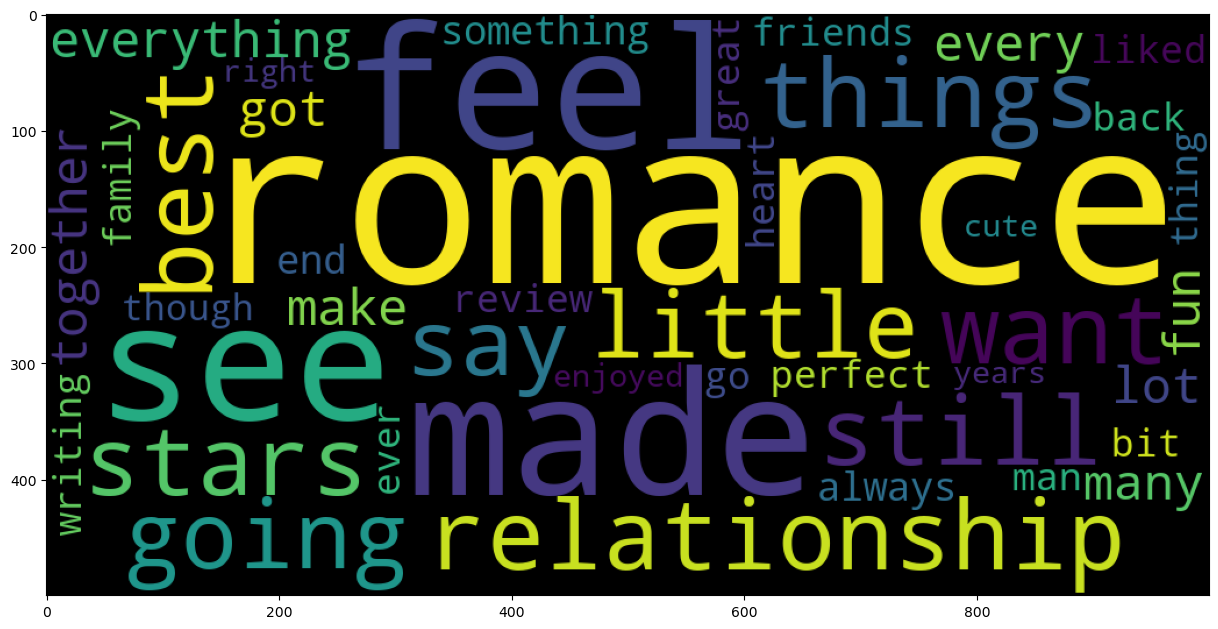

In [12]:
wordcloud = WordCloud(width=1000, height=500).generate_from_frequencies(genres_data.loc["Romance", "interesting_words"])

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)

##### Fantasy

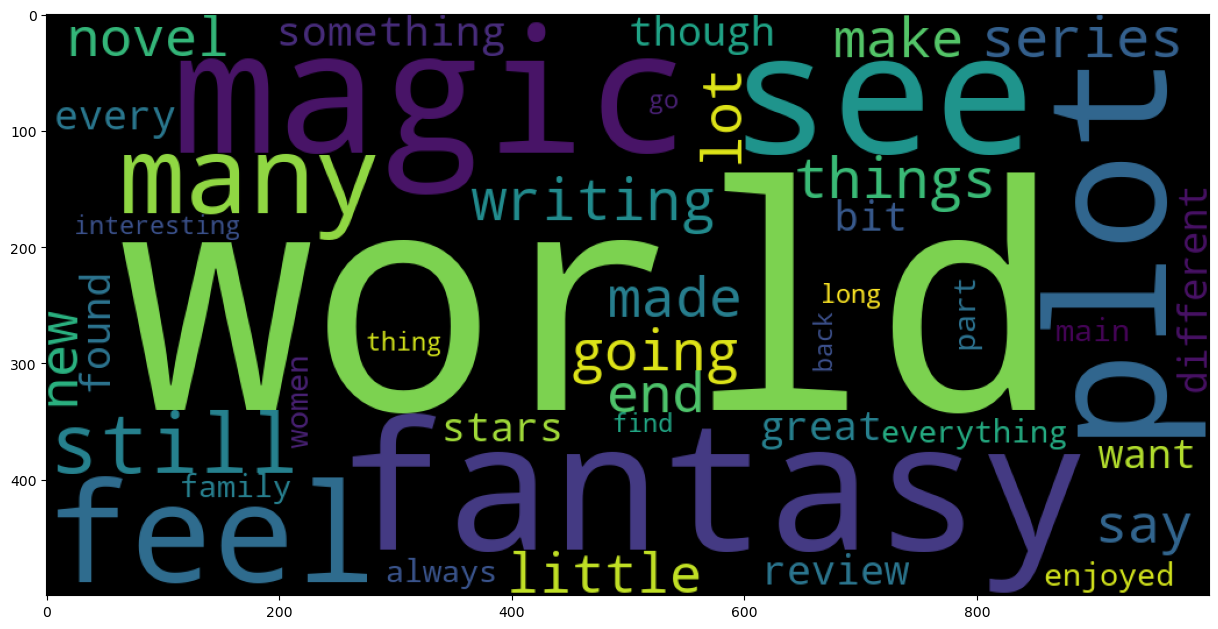

In [13]:
wordcloud = WordCloud(width=1000, height=500).generate_from_frequencies(genres_data.loc["Fantasy", "interesting_words"])

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)

##### Mystery & Thriller

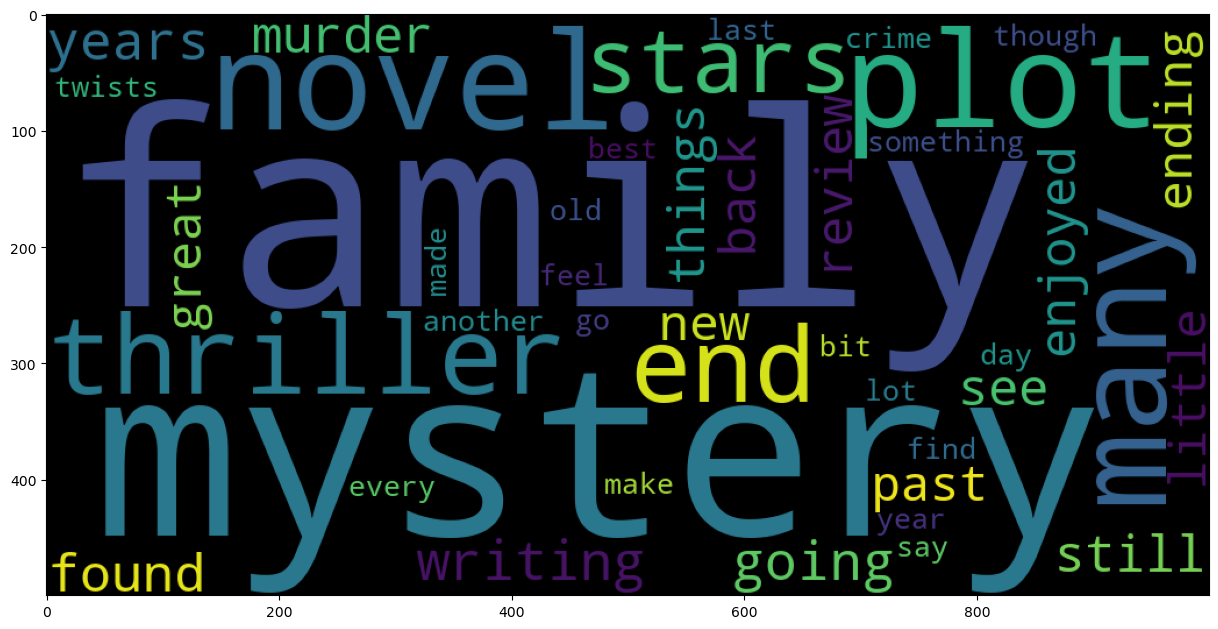

In [14]:
wordcloud = WordCloud(width=1000, height=500).generate_from_frequencies(genres_data.loc["Mystery & Thriller", "interesting_words"])

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)

##### Historical Fiction

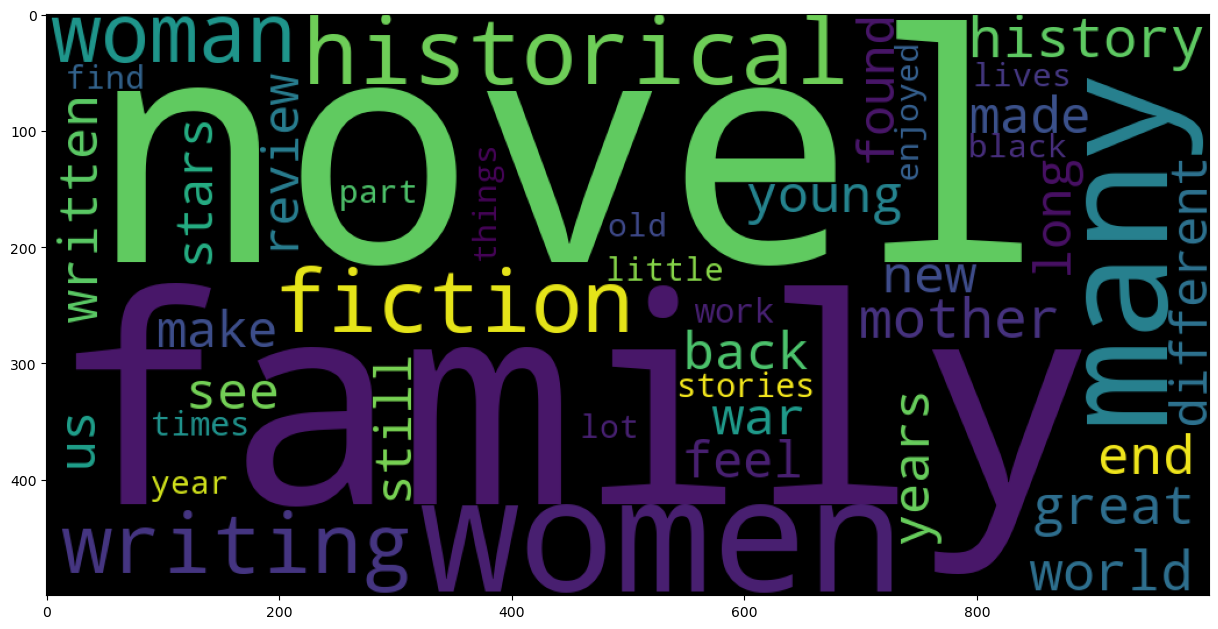

In [15]:
wordcloud = WordCloud(width=1000, height=500).generate_from_frequencies(genres_data.loc["Historical Fiction", "interesting_words"])

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)

##### Fiction

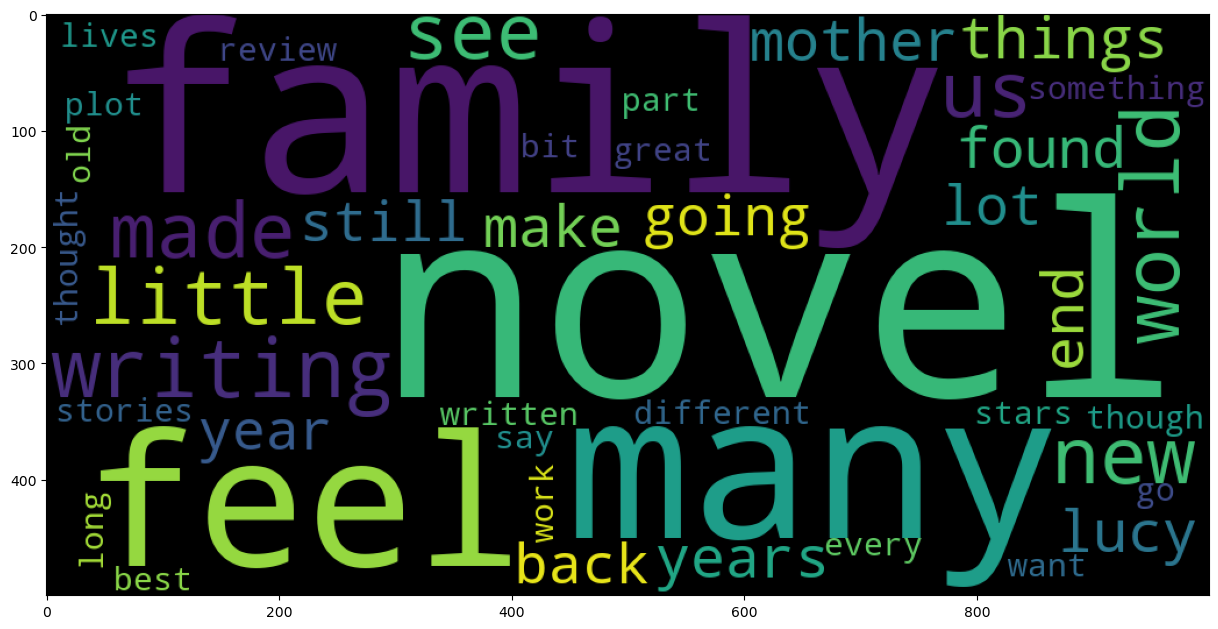

In [16]:
wordcloud = WordCloud(width=1000, height=500).generate_from_frequencies(genres_data.loc["Fiction", "interesting_words"])

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)

### 2- Author and Genre Analysis:

In [53]:
# Group by Author and Genre to get counts and total votes
author_genre_votes_df = df.groupby(['Author', 'Genre']).agg({
    'Title': 'count',
    'Votes': 'sum',
    'mean sentiment value': 'mean'
}).rename(columns={'Title': 'Book Count', 'Votes': 'Total Votes', 'mean sentiment value': 'Avg Sentiment'})


In [52]:
# Determine the predominant genre each author writes in
# This involves finding the genre with the highest book count for each author
predominant_genre_df = author_genre_votes_df.reset_index().sort_values(['Total Votes', 'Book Count'], ascending=[False, False]).drop_duplicates('Author')

In [54]:
# Get the highest-voted authors from each genre
# Sort by Genre and Total Votes, then drop duplicates to keep the highest for each genre
top_authors_per_genre = predominant_genre_df.sort_values('Total Votes', ascending= False).drop_duplicates('Genre')

top_authors_per_genre

,Author,Genre,Book Count,Total Votes,Avg Sentiment
249,Emily Henry,Romance,3,422299,0.776468
688,Rebecca Yarros,Romantasy,1,397565,0.630812
739,Sarah J. Maas,Fantasy,2,217216,0.444290
810,Taylor Jenkins Reid,Historical Fiction,2,205599,0.767542
379,Jennette McCurdy,Memoir & Autobiography,1,202606,0.213385
668,R.F. Kuang,Fiction,1,200722,0.374251
384,Jennifer Lynn Barnes,Young Adult Fiction,3,172328,0.476361
33,Alice Oseman,Graphic Novels & Comics,1,138174,0.575323
686,Rebecca Ross,Young Adult Fantasy & Science Fiction,1,117671,0.605193
691,Richard Osman,Mystery & Thriller,2,104552,0.485548


### 3- Linguistic Patterns in Top Genres:

The given code analyses sentiment values on genres over three years and then visualises them with Matplotlib.

In [ ]:


# Example data
data = {
    'Year': [2021, 2021, 2021, 2022, 2022, 2022, 2023, 2023, 2023],
    'Genre': ['Drama', 'Comedy', 'Action', 'Drama', 'Comedy', 'Action', 'Drama', 'Comedy', 'Action'],
    'sentiment value': [0.15, 0.25, 0.45, 0.65, 0.45, 0.55, 0.75, 0.45, 0.65]
}
df = pd.DataFrame(data)

# Actual data
df = pd.read_json("cleaned_text.json")

# Convert the sentiment value column to numerical values, non-convertible values are NaN
df['sentiment value'] = pd.to_numeric(df['mean sentiment value'], errors='coerce')

# Remove rows with NaN in the sentiment value column
df = df.dropna(subset=['sentiment value'])

# Find the genres that are present in all three years
genres_per_year = df.groupby('Year')['Genre'].unique()
common_genres = set(genres_per_year.iloc[0])
for genres in genres_per_year[1:]:
    common_genres.intersection_update(genres)

# Filter data by common genres
df = df[df['Genre'].isin(common_genres)]

# Group by year and genre, and calculate the average sentiment value
grouped = df.groupby(['Year', 'Genre'])['sentiment value'].mean().reset_index()

# Calculate the range (max - min) of sentiment values for each genre
range_per_genre = grouped.groupby('Genre')['sentiment value'].agg(lambda x: x.max() - x.min())

# Keep the top 9 genres with the highest range (most variability)
top_9_genres = range_per_genre.sort_values(ascending=False).head(9).index

# Filter the data to include only the top 9 genres
grouped = grouped[grouped['Genre'].isin(top_9_genres)]

# Calculate the overall average sentiment value for each year
overall_avg_per_year = df.groupby('Year')['sentiment value'].mean().reset_index()
overall_avg_per_year['Genre'] = 'Overall Average'

# Append overall average to the grouped data
grouped = pd.concat([grouped, overall_avg_per_year.rename(columns={'sentiment value': 'sentiment value'})])

# Create pivot table to have years as index and genres as columns
pivot_table = grouped.pivot(index='Year', columns='Genre', values='sentiment value')

# Create plot
pivot_table.plot(kind='line', marker='', figsize=(12, 6))

# Label diagram
plt.title('Average Sentiment Value by Genre over the Past Three Years')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Value')
plt.legend(title='Genre', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.xticks([2021, 2022, 2023])

# Align diagram (centered)
plt.tight_layout()

# Show diagram
plt.show()



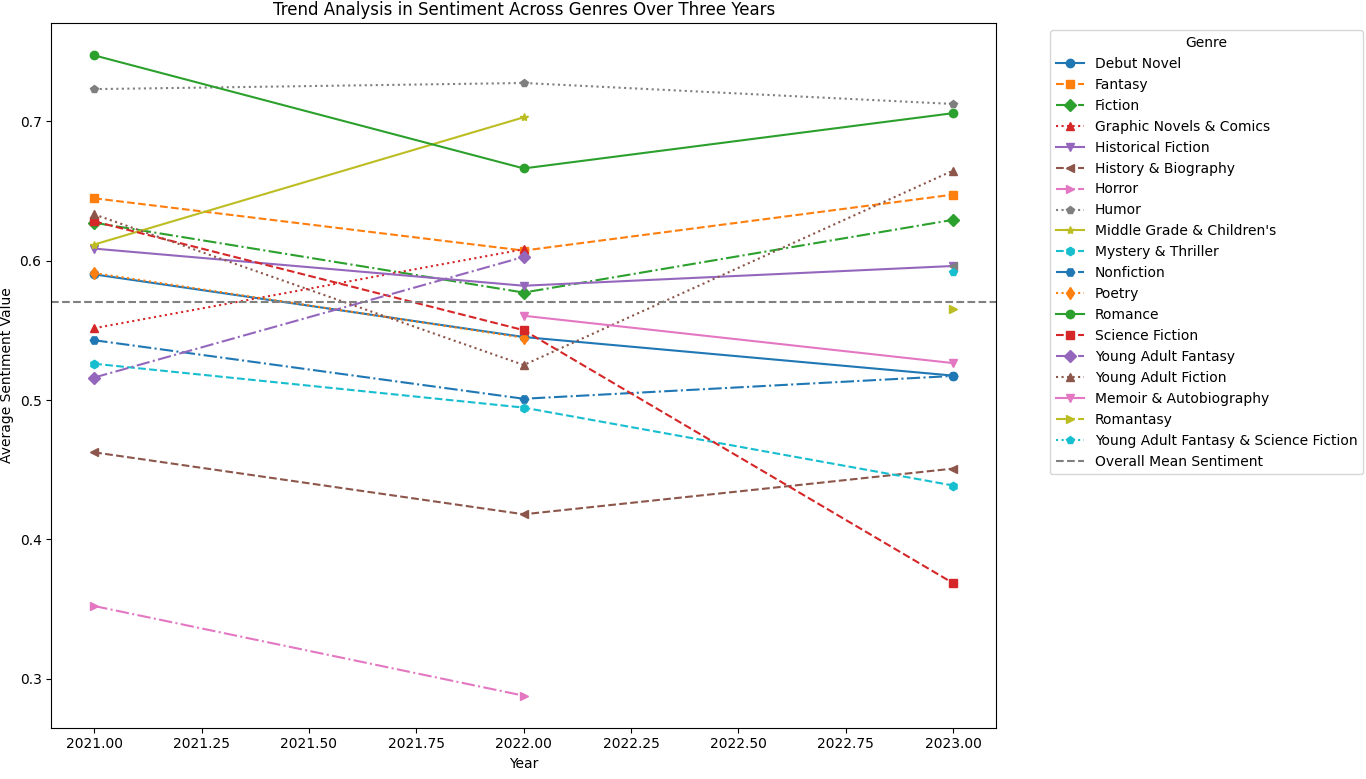

In [5]:
Image("sentiment_genre.png")

### 4- Trend Analysis in Sentiment:

In [2]:
data = pd.read_json("cleaned_text.json")
sentiment_genre_year=data.groupby(["Genre", "Year"])[["mean sentiment value"]].median()
sentiment_genre_year=sentiment_genre_year.reset_index()
genre_list =list(data.Genre.unique())
year_list =list(data.Year.unique())

##### Interactive Selection of Genre for trend analysis

In [3]:
@interact(x=genre_list)
def func(x):
    selection = sentiment_genre_year.loc[(sentiment_genre_year["Year"].isin(year_list)) & (sentiment_genre_year["Genre"] == x), :]
    years = [str(year) for year in selection["Year"].unique()]
    mean_sentiment_values = selection.groupby("Year")["mean sentiment value"].mean()
    plt.bar(years, mean_sentiment_values)
    plt.xlabel("Year")
    plt.ylabel("Mean Sentiment Value")
    plt.title(f"Mean Sentiment Value for Genre {x} Over Years")
    plt.show()

interactive(children=(Dropdown(description='x', options=('Fiction', 'Historical Fiction', 'Mystery & Thriller'…

##### Trend for Sentiment in Science Fiction

Interestingly the sentiment in reviews for books in the category science fiction have been steadily decreasing since 2021

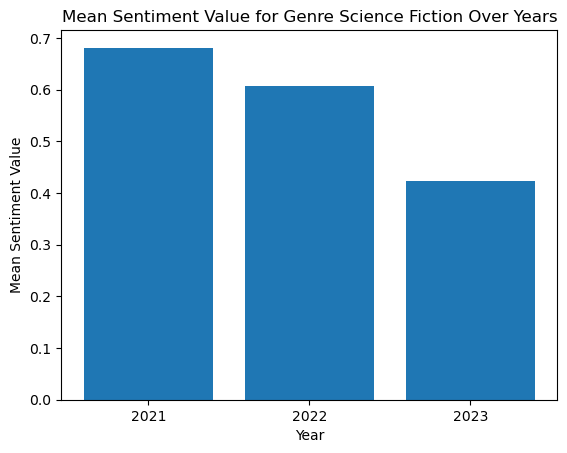

In [4]:
selection = sentiment_genre_year.loc[(sentiment_genre_year["Year"].isin(year_list)) & (sentiment_genre_year["Genre"] == "Science Fiction"), :]
years = [str(year) for year in selection["Year"].unique()]
mean_sentiment_values = selection.groupby("Year")["mean sentiment value"].mean()
plt.bar(years, mean_sentiment_values)
plt.xlabel("Year")
plt.ylabel("Mean Sentiment Value")
plt.title(f"Mean Sentiment Value for Genre Science Fiction Over Years")
plt.show()

### 5- Rating Versus Sentiment Comparison:

In [20]:
# Get the 5 most popular genres in a list
most_popular= list(genres_data.index)


Pre-processing for the comparison: create lists for the top and bottom 50 of reviews based on star rating given by users and the deducted rating through our sentiment analysis

In [22]:
# select every book with a genre that is in the top 5 genres 
sentiment_rating_comparison=data[data["Genre"].isin(most_popular)][["Title","Overall Rating", "mean sentiment value", "sentiment"]]


In [23]:
# create top and bottom list of reviews based on star rating
top_rating=sentiment_rating_comparison.sort_values(by="Overall Rating").tail(50)
bot_rating=sentiment_rating_comparison.sort_values(by="Overall Rating").head(50)

In [24]:
# create top and bottom list of reviews based on sentiment rating
top_sentiment=sentiment_rating_comparison.sort_values(by="mean sentiment value").tail(50)
bot_sentiment=sentiment_rating_comparison.sort_values(by="mean sentiment value").head(50)

In [25]:
# Create the comparison on how many reviews match between the two types of rating
top_rating["Matching Sentiment?"]=top_rating["Title"].isin(top_sentiment["Title"])
bot_rating["Matching Sentiment?"]=bot_rating["Title"].isin(bot_sentiment["Title"])

#### How many of the top 50 books by rating  are also in the top 50 by sentiment? 

In [26]:
top_rating["Matching Sentiment?"].sum()

7

#### How many of the bot 50 books by rating  are also in the bot 50 by sentiment? 

In [27]:
bot_rating["Matching Sentiment?"].sum()

8

#### Comparison between Rating and Sentiment

In [28]:
# Select books, where the star rating overall is positive, while their overall sentiment isn't
sentiment_rating_comparison[(sentiment_rating_comparison["Overall Rating"]>=4.0) & (sentiment_rating_comparison["sentiment"].isin(["negative", "neutral"]))]

,Title,Overall Rating,mean sentiment value,sentiment
302,Notes on an Execution,4.08,-0.085013,negative
658,Razorblade Tears,4.10,-0.049373,neutral


In [ ]:
sentiment_rating_comparison[(sentiment_rating_comparison["Overall Rating"]<4.0) & (sentiment_rating_comparison["mean sentiment value"]>=0.5)] # Mean sentiment value >= 0.5 instead of just a 
                                                                                                                                            #positive sentiment so we only get books that
                                                                                                                                            # have a considerable positive sentiment

,Title,Overall Rating,mean sentiment value,sentiment
5,Someone Else's Shoes,3.96,0.582148,positive
6,The Invisible Hour,3.61,0.773223,positive
9,Pineapple Street,3.57,0.666257,positive
12,The Celebrants,3.64,0.783987,positive
13,Birnam Wood,3.82,0.626067,positive
...,...,...,...,...
723,The Ex Talk,3.69,0.749829,positive
724,While We Were Dating,3.74,0.844883,positive
725,The Dating Plan,3.63,0.727005,positive
726,Shipped,3.63,0.828012,positive


# Lessons Learned

#### 1. Project Planning and Scope Management
 We initially planned to gather data from all years of the Good Choice Awards. However, we realized that the amount of data was way more than we expected. Because of this, we had to limit our data collection to the last three years. This taught us that our plans might need to change as the project progresses.

#### 2. Data Handling and Processing
With so much data, we learned that it's best to test our code on smaller sections of the data first. This made it easier to refine our methods. We also used the try-except method effectively, and learned how important it is for handling errors.

#### 3. Time Management
We recognized that we could have managed our time better throughout the project. More efficient scheduling and task allocation would have helped us meet our deadlines more comfortably.

#### 4. Teamwork and Collaboration
Working on this project as a group taught us a lot about teamwork and sharing tasks. We learned how to collaborate effectively and make the most of each team member's strengths.

#### 5. Tool Selection and Performance
We realized that we might need more powerful and faster tools for web scraping. The tools we initially chose had their limitations, and finding better alternatives could have made the data collection process faster.

#### 6. Technical Skills Development
This project helped us improve our skills, especially with the Pandas library for data manipulation and analysis. We gained experience in handling large datasets, cleaning data, and performing complex transformations.

#### 7. Business Case Planning
We had in mind that we wanted to use natural language processing, but had difficulties finding a strong business case to make use of this technique.